# Strategie di valutazione dell'apprendimento automatico


## 1. Introduzione alla valutazione della classificazione <a id="introduction"></a>

Quando si crea un modello di classificazione, abbiamo bisogno di metodi sistematici per determinare quanto sia efficace. I problemi di classificazione si presentano in molte forme:

- Classificazione binaria (due classi, come spam vs. non spam)
- Classificazione multi-classe (più classi distinte)
- Classificazione multi-etichetta (ogni istanza può appartenere a più classi)

In questo tutorial, ci concentreremo principalmente sulle metriche di classificazione binaria, poiché costituiscono la base per comprendere scenari di valutazione più complessi.

L'approccio di valutazione ideale dipende da diversi fattori:
- La distribuzione delle classi nei dati (bilanciata vs. sbilanciata)
- Il costo relativo dei diversi tipi di errori
- Se hai bisogno di probabilità o solo di etichette di classe
- Gli obiettivi specifici della tua applicazione

Iniziamo esplorando come impostare il nostro ambiente e creare dati per illustrare questi concetti.

## 1.1 Impostazione del nostro ambiente <a id="setup"></a>

Per prima cosa, importeremo le librerie necessarie per il nostro tutorial:

In [1]:
# Import essential libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tabulate

# Machine learning libraries
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

# Evaluation metrics
from sklearn.metrics import (
    confusion_matrix, 
    accuracy_score, 
    precision_score, 
    recall_score, 
    f1_score,
    roc_curve, 
    roc_auc_score,
    precision_recall_curve, 
    average_precision_score,
)

# Visualization settings
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("viridis")
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['axes.titlesize'] = 16
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

## 1.2 Creazione di dati campione <a id="sample-data"></a>

Per illustrare le metriche di classificazione, creeremo due set di dati:
1. Un set di dati bilanciato in cui entrambe le classi compaiono con la stessa frequenza
2. Un set di dati sbilanciato in cui una classe è molto più rara dell'altra

Questo approccio ci aiuterà a capire come si comportano le diverse metriche in base a varie distribuzioni di classi.

In [2]:
# Set random seed for reproducibility
np.random.seed(42)

# Create a balanced dataset
X_balanced, y_balanced = make_classification(
    n_samples=10000,
    n_features=20,
    n_informative=10,
    n_redundant=5,
    n_classes=2,
    weights=[0.5, 0.5],  # Equal class probabilities
    random_state=42
)

# Create an imbalanced dataset (10% minority class)
X_imbalanced, y_imbalanced = make_classification(
    n_samples=10000,
    n_features=20,
    n_informative=10,
    n_redundant=5,
    n_classes=2,
    weights=[0.9, 0.1],  # Imbalanced class probabilities
    random_state=42
)

# Split datasets into training and testing sets
X_bal_train, X_bal_test, y_bal_train, y_bal_test = train_test_split(
    X_balanced, y_balanced, test_size=0.25, random_state=42
)

X_imb_train, X_imb_test, y_imb_train, y_imb_test = train_test_split(
    X_imbalanced, y_imbalanced, test_size=0.25, random_state=42
)

# Check class distributions
print("Balanced dataset class distribution:")
print(pd.Series(y_balanced).value_counts(normalize=True))
print("\nImbalanced dataset class distribution:")
print(pd.Series(y_imbalanced).value_counts(normalize=True))

Balanced dataset class distribution:
0    0.5005
1    0.4995
Name: proportion, dtype: float64

Imbalanced dataset class distribution:
0    0.8966
1    0.1034
Name: proportion, dtype: float64


Ora, addestriamo modelli semplici su entrambi i set di dati da utilizzare per l'esplorazione delle nostre metriche:

In [3]:
# Train a logistic regression model on the balanced dataset
lr_balanced = LogisticRegression(random_state=42)
lr_balanced.fit(X_bal_train, y_bal_train)

# Train a logistic regression model on the imbalanced dataset
lr_imbalanced = LogisticRegression(random_state=42)
lr_imbalanced.fit(X_imb_train, y_imb_train)

# Generate predictions and probability scores
y_bal_pred = lr_balanced.predict(X_bal_test)
y_bal_prob = lr_balanced.predict_proba(X_bal_test)[:, 1]

y_imb_pred = lr_imbalanced.predict(X_imb_test)
y_imb_prob = lr_imbalanced.predict_proba(X_imb_test)[:, 1]

# Train a second model (Random Forest) for comparison
rf_balanced = RandomForestClassifier(random_state=42)
rf_balanced.fit(X_bal_train, y_bal_train)
y_bal_pred_rf = rf_balanced.predict(X_bal_test)
y_bal_prob_rf = rf_balanced.predict_proba(X_bal_test)[:, 1]

rf_imbalanced = RandomForestClassifier(random_state=42)
rf_imbalanced.fit(X_imb_train, y_imb_train)
y_imb_pred_rf = rf_imbalanced.predict(X_imb_test)
y_imb_prob_rf = rf_imbalanced.predict_proba(X_imb_test)[:, 1]

## 1.3 Metriche di classificazione di base <a id="basic-metrics"></a>

Il fondamento della valutazione della classificazione è la comprensione dei quattro possibili risultati di un classificatore binario:

- **Veri positivi (TP)**: casi positivi previsti correttamente
- **Falsi positivi (FP)**: casi positivi previsti in modo errato (errore di tipo I)
- **Veri negativi (TN)**: casi negativi previsti correttamente
- **Falsi negativi (FN)**: casi negativi previsti in modo errato (errore di tipo II)

Questi quattro valori costituiscono la base per quasi tutte le metriche di classificazione che discuteremo.

### Matrice di confusione <a id="confusion-matrix"></a>

Una matrice di confusione visualizza i quattro possibili risultati in una griglia 2×2. È la base per comprendere le prestazioni di classificazione.

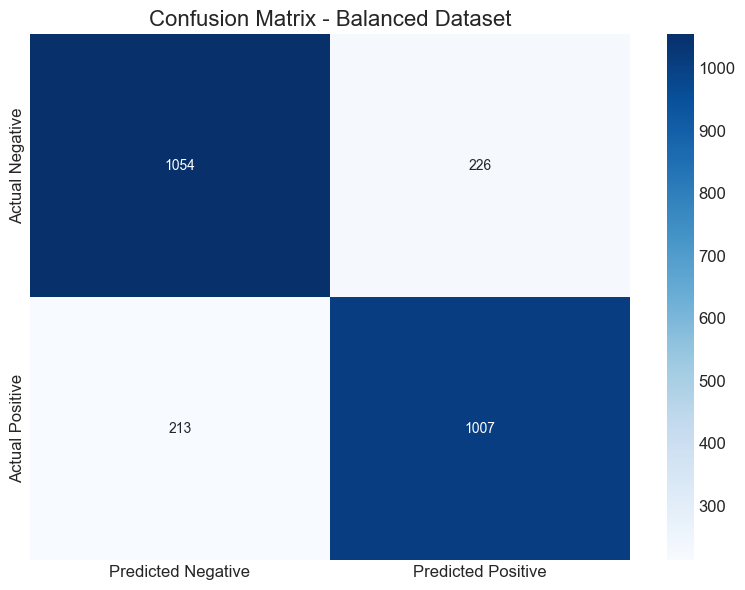

True Positives (TP): 1007
False Positives (FP): 226
True Negatives (TN): 1054
False Negatives (FN): 213


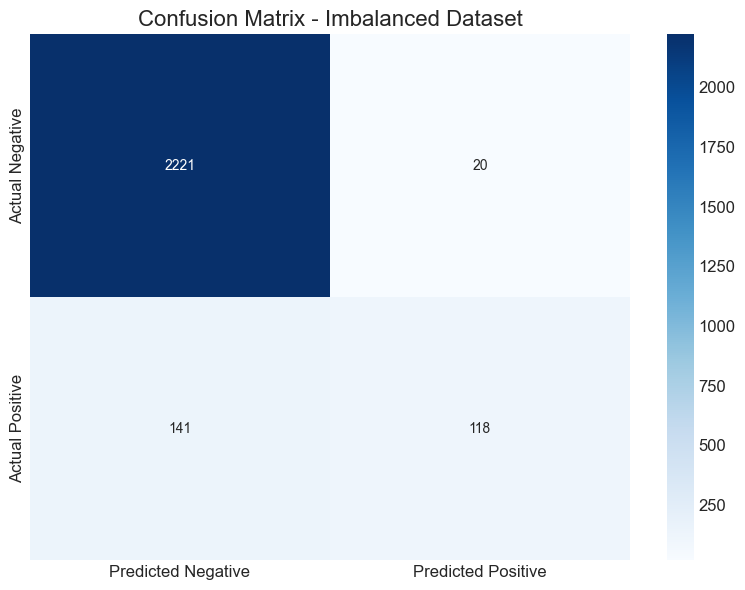

True Positives (TP): 118
False Positives (FP): 20
True Negatives (TN): 2221
False Negatives (FN): 141


In [4]:
def plot_confusion_matrix(y_true, y_pred, title):
    # Calculate confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    
    # Extract values for annotation
    tn, fp, fn, tp = cm.ravel()
    
    # Create a heatmap visualization
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['Predicted Negative', 'Predicted Positive'],
                yticklabels=['Actual Negative', 'Actual Positive'])
    
    plt.title(title, fontsize=16)
    plt.tight_layout()
    plt.show()
    
    # Print TP, FP, TN, FN values
    print(f"True Positives (TP): {tp}")
    print(f"False Positives (FP): {fp}")
    print(f"True Negatives (TN): {tn}")
    print(f"False Negatives (FN): {fn}")

# Plot confusion matrices for both datasets
plot_confusion_matrix(y_bal_test, y_bal_pred, "Confusion Matrix - Balanced Dataset")
plot_confusion_matrix(y_imb_test, y_imb_pred, "Confusion Matrix - Imbalanced Dataset")

### Accuratezza <a id="accuracy"></a>

L'accuratezza misura la proporzione di previsioni corrette rispetto al numero totale di previsioni. Sebbene intuitiva, può essere fuorviante per set di dati sbilanciati.

In [5]:
# Calculate accuracy for both datasets
balanced_accuracy = accuracy_score(y_bal_test, y_bal_pred)
imbalanced_accuracy = accuracy_score(y_imb_test, y_imb_pred)

print(f"Balanced dataset accuracy: {balanced_accuracy:.4f}")
print(f"Imbalanced dataset accuracy: {imbalanced_accuracy:.4f}")

# Let's see what happens if we always predict the majority class in the imbalanced dataset
majority_predictions = np.zeros_like(y_imb_test)  # Assuming 0 is the majority class
majority_accuracy = accuracy_score(y_imb_test, majority_predictions)
print(f"Imbalanced dataset - majority class baseline accuracy: {majority_accuracy:.4f}")

Balanced dataset accuracy: 0.8244
Imbalanced dataset accuracy: 0.9356
Imbalanced dataset - majority class baseline accuracy: 0.8964


Come possiamo vedere, l'accuratezza può essere fuorviante con dati sbilanciati, poiché un modello che prevede sempre la classe di maggioranza otterrà comunque un'accuratezza apparentemente elevata. Questo mostra perché abbiamo bisogno di metriche più sfumate per problemi di classificazione sbilanciati.

### Precisione <a id="precisione"></a>

La precisione misura quante delle istanze positive previste sono effettivamente positive. È fondamentale quando il costo dei falsi positivi è elevato.

$$\text{Precisione} = \frac{TP}{TP + FP}$$

In [6]:
# Calculate precision for both datasets
balanced_precision = precision_score(y_bal_test, y_bal_pred)
imbalanced_precision = precision_score(y_imb_test, y_imb_pred)

print(f"Balanced dataset precision: {balanced_precision:.4f}")
print(f"Imbalanced dataset precision: {imbalanced_precision:.4f}")

Balanced dataset precision: 0.8167
Imbalanced dataset precision: 0.8551


### Richiamo <a id="recall"></a>

Il richiamo (chiamato anche sensibilità) misura quanti dei casi positivi effettivi sono stati correttamente identificati dal nostro modello. È importante quando perdere casi positivi è costoso.

$$\text{Richiamo} = \frac{TP}{TP + FN}$$

In [7]:
# Calculate recall for both datasets
balanced_recall = recall_score(y_bal_test, y_bal_pred)
imbalanced_recall = recall_score(y_imb_test, y_imb_pred)

print(f"Balanced dataset recall: {balanced_recall:.4f}")
print(f"Imbalanced dataset recall: {imbalanced_recall:.4f}")

Balanced dataset recall: 0.8254
Imbalanced dataset recall: 0.4556


### F1 Score <a id="f1-score"></a>

Il F1 SCORE è la media armonica di precisione e richiamo, che fornisce un equilibrio tra di essi. È particolarmente utile per set di dati sbilanciati.

$$F1 = 2 \times \frac{\text{Precision} \times \text{Recall}}{\text{Precision} + \text{Recall}}$$

In [8]:
# Calculate F1 score for both datasets
balanced_f1 = f1_score(y_bal_test, y_bal_pred)
imbalanced_f1 = f1_score(y_imb_test, y_imb_pred)

print(f"Balanced dataset F1 score: {balanced_f1:.4f}")
print(f"Imbalanced dataset F1 score: {imbalanced_f1:.4f}")

Balanced dataset F1 score: 0.8210
Imbalanced dataset F1 score: 0.5945


### Specificità <a id="specificity"></a>

La specificità misura quanto bene il modello identifica i casi negativi. È il complemento del tasso di falsi positivi.

$$\text{Specificità} = \frac{TN}{TN + FP}$$

In [9]:
# Calculate specificity manually (not directly available in sklearn)
def specificity_score(y_true, y_pred):
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    return tn / (tn + fp)

balanced_specificity = specificity_score(y_bal_test, y_bal_pred)
imbalanced_specificity = specificity_score(y_imb_test, y_imb_pred)

print(f"Balanced dataset specificity: {balanced_specificity:.4f}")
print(f"Imbalanced dataset specificity: {imbalanced_specificity:.4f}")

Balanced dataset specificity: 0.8234
Imbalanced dataset specificity: 0.9911


## 1.4 Valutazione basata sulla soglia <a id="threshold-evaluation"></a>

La maggior parte degli algoritmi di classificazione non si limita a prevedere le classi; generano punteggi di probabilità che vengono convertiti in etichette di classe utilizzando una soglia (in genere 0,5). Regolando questa soglia, possiamo effettuare un compromesso tra diversi tipi di errori.

### Curva ROC e AUC <a id="roc-curve"></a>

La curva Receiver Operating Characteristic (ROC) traccia il tasso di veri positivi (richiamo) rispetto al tasso di falsi positivi a varie impostazioni di soglia. L'area sotto la curva (AUC) fornisce una metrica singola che misura le prestazioni complessive su tutte le soglie.

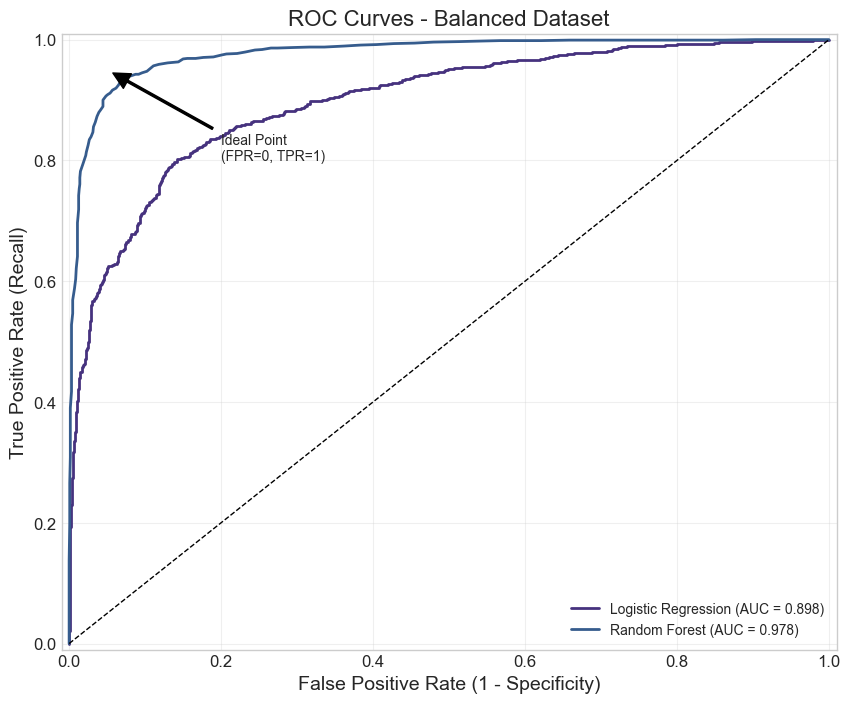

In [ ]:
def plot_roc_curves(models_data, title):
    plt.figure(figsize=(10, 8))
    
    for label, data in models_data.items():
        y_true, y_prob = data
        
        # Calculate ROC curve
        fpr, tpr, thresholds = roc_curve(y_true, y_prob)
        auc = roc_auc_score(y_true, y_prob)
        
        # Plot ROC curve
        plt.plot(fpr, tpr, linewidth=2, label=f"{label} (AUC = {auc:.3f})")
    
    # Add diagonal line (random classifier)
    plt.plot([0, 1], [0, 1], 'k--', linewidth=1)
    
    # Add labels and legend
    plt.xlabel('False Positive Rate (1 - Specificity)')
    plt.ylabel('True Positive Rate (Recall)')
    plt.title(title)
    plt.legend(loc='lower right')
    plt.grid(True, alpha=0.3)
    
    # Adjust axes
    plt.xlim([-0.01, 1.01])
    plt.ylim([-0.01, 1.01])

    plt.annotate('Ideal Point\n(FPR=0, TPR=1)', xy=(0.05, 0.95), xytext=(0.2, 0.8), arrowprops=dict(facecolor='black', shrink=0.05, width=1.5))
    
    plt.show()

# Compare logistic regression and random forest on both datasets
balanced_models = {
    'Logistic Regression': (y_bal_test, y_bal_prob),
    'Random Forest': (y_bal_test, y_bal_prob_rf)
}

imbalanced_models = {
    'Logistic Regression': (y_imb_test, y_imb_prob),
    'Random Forest': (y_imb_test, y_imb_prob_rf)
}

plot_roc_curves(balanced_models, "ROC Curves - Balanced Dataset")
plot_roc_curves(imbalanced_models, "ROC Curves - Imbalanced Dataset")

### Curva Precision-Recall <a id="pr-curve"></a>

La curva Precision-Recall (PR) traccia la precisione rispetto al recall a diverse impostazioni di soglia. È particolarmente utile per set di dati sbilanciati in cui la curva ROC potrebbe essere eccessivamente ottimistica.

In [ ]:
def plot_pr_curves(models_data, title):
    plt.figure(figsize=(10, 8))
    
    for label, data in models_data.items():
        y_true, y_prob = data
        
        # Calculate PR curve
        precision, recall, thresholds = precision_recall_curve(y_true, y_prob)
        ap = average_precision_score(y_true, y_prob)
        
        # Plot PR curve
        plt.plot(recall, precision, linewidth=2, label=f"{label} (AP = {ap:.3f})")
    
    # Add baseline (no-skill classifier)
    no_skill = sum(y_true) / len(y_true)  # Frequency of positive class
    plt.plot([0, 1], [no_skill, no_skill], 'k--', linewidth=1, label=f'No Skill (AP = {no_skill:.3f})')
    
    # Add labels and legend
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title(title)
    plt.legend(loc='best')
    plt.grid(True, alpha=0.3)
    
    # Adjust axes
    plt.xlim([-0.01, 1.01])
    plt.ylim([-0.01, 1.01])

    plt.annotate('Ideal Point\n(Recall=1, Precision=1)', xy=(0.9, 0.95), xytext=(0.6, 0.9),
                arrowprops=dict(facecolor='black', shrink=0.05, width=1.5))
    
    plt.show()

# Plot PR curves for both datasets
plot_pr_curves(balanced_models, "Precision-Recall Curves - Balanced Dataset")
plot_pr_curves(imbalanced_models, "Precision-Recall Curves - Imbalanced Dataset")

## 1.5 Compromessi nella valutazione della classificazione <a id="tradeoffs"></a>

Approfondiamo i compromessi tra diverse metriche di performance e concentriamoci in particolare su quando utilizzare le curve ROC rispetto a quelle PR.

In [ ]:
def analyze_thresholds(y_true, y_prob, thresholds, model_name, dataset_name, num_points=10):
    # Select a subset of thresholds to analyze
    indices = np.linspace(0, len(thresholds) - 1, num_points, dtype=int)
    selected_thresholds = thresholds[indices]
    
    # Calculate metrics for each threshold
    results = []
    for threshold in selected_thresholds:
        y_pred = (y_prob >= threshold).astype(int)
        tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
        tpr = tp / (tp + fn) if (tp + fn) > 0 else 0  # Recall/Sensitivity
        fpr = fp / (fp + tn) if (fp + tn) > 0 else 0
        tnr = tn / (tn + fp) if (tn + fp) > 0 else 0  # Specificity
        precision = tp / (tp + fp) if (tp + fp) > 0 else 0
        f1 = 2 * precision * tpr / (precision + tpr) if (precision + tpr) > 0 else 0
        
        results.append({
            'Threshold': threshold,
            'TP': tp, 'FP': fp, 'TN': tn, 'FN': fn,
            'Precision': precision,
            'Recall (TPR)': tpr,
            'Specificity (TNR)': tnr,
            'FPR': fpr,
            'F1 Score': f1
        })
    
    # Convert to DataFrame for better display
    results_df = pd.DataFrame(results)
    print(f"Threshold analysis for {model_name} on {dataset_name}:")
    return results_df

# Analyze thresholds for Logistic Regression on imbalanced dataset
precision, recall, thresholds = precision_recall_curve(imbalanced_models['Logistic Regression'][0], imbalanced_models['Logistic Regression'][1])

log_reg_imb_thresholds = analyze_thresholds(
    y_imb_test, 
    imbalanced_models['Logistic Regression'][1],
    thresholds,
    'Logistic Regression',
    'Imbalanced Dataset'
)

# Display the results
pd.set_option('display.precision', 3)
display(log_reg_imb_thresholds[['Threshold', 'Precision', 'Recall (TPR)', 'Specificity (TNR)', 'F1 Score']])

In [ ]:
def plot_threshold_tradeoffs(threshold_df):
    plt.figure(figsize=(12, 7))
    
    plt.plot(threshold_df['Threshold'], threshold_df['Precision'], 'b-', label='Precision')
    plt.plot(threshold_df['Threshold'], threshold_df['Recall (TPR)'], 'r-', label='Recall (TPR)')
    plt.plot(threshold_df['Threshold'], threshold_df['Specificity (TNR)'], 'g-', label='Specificity (TNR)')
    plt.plot(threshold_df['Threshold'], threshold_df['F1 Score'], 'y-', label='F1 Score')
    
    plt.axvline(x=0.5, color='k', linestyle='--', alpha=0.3, label='Default Threshold (0.5)')
    
    plt.xlabel('Classification Threshold')
    plt.ylabel('Metric Value')
    plt.title('How Classification Metrics Change with Threshold')
    plt.legend(loc='center right')
    plt.grid(True, alpha=0.3)
    
    # Add annotation about the decision point
    f1_max_idx = threshold_df['F1 Score'].argmax()
    optimal_threshold = threshold_df.iloc[f1_max_idx]['Threshold']
    
    plt.scatter(optimal_threshold, threshold_df.iloc[f1_max_idx]['F1 Score'], 
                s=100, c='black', marker='*')
    plt.annotate(f'Optimal F1 Threshold: {optimal_threshold:.3f}', 
                 xy=(optimal_threshold, threshold_df.iloc[f1_max_idx]['F1 Score']),
                 xytext=(optimal_threshold+0.2, threshold_df.iloc[f1_max_idx]['F1 Score']-0.1),
                 arrowprops=dict(facecolor='black', shrink=0.05, width=1.5))
    
    plt.show()

# Plot the threshold tradeoffs
plot_threshold_tradeoffs(log_reg_imb_thresholds)

### Approfondimenti chiave sulle curve ROC

1. **Interpretazione della curva ROC**:
- La linea diagonale rappresenta un classificatore casuale (AUC = 0,5)
- Le curve più vicine all'angolo in alto a sinistra indicano prestazioni migliori (AUC più vicina a 1,0)
- L'area sotto la curva (AUC) fornisce un singolo numero per confrontare i modelli

2. **Compromessi nella selezione della soglia**:
- Soglie più basse: maggiore richiamo (TPR), ma anche maggiori falsi positivi (FPR)
- Soglie più alte: minori falsi positivi, ma anche minore richiamo
- La soglia "migliore" dipende dai costi specifici dei falsi positivi rispetto ai falsi negativi nella tua applicazione

3. **Limitazioni delle curve ROC**:
- Possono essere fuorvianti per set di dati sbilanciati
- Non mostrano direttamente la precisione, che è spesso importante in scenari sbilanciati

In [ ]:
# Summary of key classification metrics and when to use them

metrics_summary = pd.DataFrame({
    'Metric': [
        'Accuracy', 'Precision', 'Recall (Sensitivity)', 'Specificity', 
        'F1 Score', 'AUC-ROC', 'Average Precision (AP)', 'Balanced Accuracy'
    ],
    'Description': [
        'Proporzione di previsioni corrette (TP+TN)/(TP+TN+FP+FN)',
        'Proporzione di previsioni positive corrette TP/(TP+FP)',
        'Proporzione di positivi effettivi correttamente identificati TP/(TP+FN)',
        'Proporzione di negativi effettivi correttamente identificati TN/(TN+FP)',
        'Media armonica di precisione e richiamo 2*(P*R)/(P+R)',
        'Area sotto la curva ROC (TPR vs FPR)',
        'Area sotto la curva precisione-richiamo',
        'Media di richiamo e specificità (TPR+TNR)/2'
    ],
    'When to Use': [
        'Set di dati bilanciati, costi di classificazione errati uguali',
        'Quando i falsi positivi sono costosi (rilevamento spam, filtraggio dei contenuti)',
        'Quando i falsi negativi sono costosi (rilevamento delle malattie, monitoraggio delle frodi)',
        'Quando è importante identificare correttamente i negativi (screening medico)',
        'Quando è necessario un equilibrio tra precisione e richiamo, set di dati sbilanciati',
        'Confronto tra modelli, set di dati bilanciati, prestazioni di classificazione',
        'Set di dati sbilanciati, concentrarsi sulle prestazioni di classe positive',
        'Set di dati sbilanciati, quando entrambe le classi sono importanti'
    ]
})

pd.set_option('display.max_colwidth',100)  
display(metrics_summary)

## 1.6 Conclusione: punti chiave per le metriche di classificazione

1. **Nessuna metrica perfetta**: la scelta della metrica di valutazione dovrebbe essere in linea con il tuo problema specifico e i requisiti aziendali. Non esiste un approccio valido per tutti.

2. **Comprendere lo squilibrio di classe**: lo squilibrio di classe influisce in modo significativo sulle metriche più informative. L'accuratezza può essere fuorviante con dati sbilanciati.

3. **Considerare il costo degli errori**: diversi tipi di errori (falsi positivi vs. falsi negativi) hanno spesso costi reali diversi. Le tue metriche dovrebbero riflettere questi costi.

4. **Curve ROC vs. PR**:
- Le curve ROC sono migliori per set di dati bilanciati e quando entrambe le classi sono importanti
- Le curve PR sono migliori per set di dati non bilanciati e quando la classe positiva è più importante

5. **Selezione della soglia**: la scelta della soglia giusta implica la comprensione dei compromessi tra le metriche e dovrebbe basarsi sui requisiti specifici della tua applicazione.

6. **Oltre la classificazione binaria**: per problemi multi-classe, considera metriche come medie macro/micro/ponderate di metriche per classe, matrici di confusione e Kappa di Cohen.

7. **Valuta con più metriche**: usa una combinazione di metriche per ottenere una visione completa delle prestazioni del modello anziché ottimizzare per una singola metrica.

8. **Il contesto è importante**: interpreta sempre le metriche nel contesto del tuo dominio di problemi specifico e delle prestazioni di base.

Comprendendo queste metriche di valutazione e i relativi compromessi, puoi prendere decisioni più consapevoli sulla selezione del modello e sull'ottimizzazione della soglia per il tuo caso d'uso specifico.

## 1.7 Esempio di scenario reale: rilevamento delle frodi

In [ ]:

# Let's create a practical example of how threshold selection impacts a real-world scenario
def threshold_business_impact_simulation(avg_transaction,fraud_cost_multiple,review_cost):
    """
    Simulates a business case to show how threshold selection impacts outcomes.
    """
    # Let's simulate a fraud detection scenario
    np.random.seed(42)
    
    # Create synthetic data for a fraud detection case
    # Assume 5% of transactions are fraudulent
    n_samples = 100000
    n_fraud = int(n_samples * 0.05)
    n_legitimate = n_samples - n_fraud
    
    # Generate probabilities for fraudulent transactions (higher scores)
    fraud_probs = np.random.beta(2, 5, n_fraud)
    # Shift to make them higher probability
    fraud_probs = 0.3 + fraud_probs * 0.7
    
    # Generate probabilities for legitimate transactions (lower scores)
    legitimate_probs = np.random.beta(2, 10, n_legitimate)
    # Shift to make them lower probability
    legitimate_probs = legitimate_probs * 0.8
    
    # Combine data
    y_true = np.array([1] * n_fraud + [0] * n_legitimate)
    y_prob = np.concatenate([fraud_probs, legitimate_probs])
    
    # Shuffle data
    idx = np.random.permutation(len(y_true))
    y_true = y_true[idx]
    y_prob = y_prob[idx]
    
    # Define function to calculate business impact
    def calculate_impact(threshold):
        y_pred = (y_prob >= threshold).astype(int)
        tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
        
        # Calculate costs
        undetected_fraud_cost = fn * avg_transaction * fraud_cost_multiple
        review_cost_total = (tp + fp) * review_cost
        total_cost = undetected_fraud_cost + review_cost_total
        
        # Calculate other metrics
        precision = tp / (tp + fp) if (tp + fp) > 0 else 0
        recall = tp / (tp + fn) if (tp + fn) > 0 else 0
        
        return {
            'threshold': threshold,
            'precision': precision,
            'recall': recall,
            'false_positives': fp,
            'false_negatives': fn,
            'undetected_fraud_cost': undetected_fraud_cost,
            'review_cost': review_cost_total,
            'total_cost': total_cost
        }
    
    # Calculate impact for various thresholds
    thresholds = np.linspace(0.1, 0.9, 17)
    impacts = [calculate_impact(t) for t in thresholds]
    
    # Extract values for plotting
    precision_values = [imp['precision'] for imp in impacts]
    recall_values = [imp['recall'] for imp in impacts]
    undetected_fraud_costs = [imp['undetected_fraud_cost'] for imp in impacts]
    review_costs = [imp['review_cost'] for imp in impacts]
    total_costs = [imp['total_cost'] for imp in impacts]
    
    # Find optimal threshold for minimizing total cost
    best_idx = np.argmin(total_costs)
    best_threshold = thresholds[best_idx]
    
    # Plot business impact
    plt.figure(figsize=(15, 12))


    # Plot 1: Precision and Recall vs Threshold
    plt.subplot(2, 1, 1)
    plt.plot(thresholds, precision_values, 'g-', label='Precision', linewidth=2)
    plt.plot(thresholds, recall_values, 'r-', label='Recall', linewidth=2)
    plt.axvline(x=best_threshold, color='k', linestyle='--', 
                label=f'Cost-optimal threshold = {best_threshold:.2f}')
    
    plt.xlabel('Threshold', fontsize=12)
    plt.ylabel('Metric Value', fontsize=12)
    plt.title('Precision and Recall vs. Threshold', fontsize=14)
    plt.legend(loc='best')
    plt.grid(True)
    
    # Plot 2: Costs vs Threshold
    plt.subplot(2, 1, 2)
    plt.plot(thresholds, np.array(undetected_fraud_costs)/1000, 'r-', 
             label='Undetected Fraud Cost (thousands $)', linewidth=2)
    plt.plot(thresholds, np.array(review_costs)/1000, 'g-', 
             label='Review Cost (thousands $)', linewidth=2)
    plt.plot(thresholds, np.array(total_costs)/1000, 'b-', 
             label='Total Cost (thousands $)', linewidth=3)
    plt.axvline(x=best_threshold, color='k', linestyle='--', 
                label=f'Cost-optimal threshold = {best_threshold:.2f}')
    
    # Highlight minimum cost point
    plt.scatter(best_threshold, total_costs[best_idx]/1000, color='blue', s=100, zorder=5)
    
    plt.xlabel('Threshold', fontsize=12)
    plt.ylabel('Cost (thousands $)', fontsize=12)
    plt.title('Business Costs vs. Threshold', fontsize=14)
    plt.legend(loc='best')
    plt.grid(True)
    
    plt.tight_layout()
    plt.show()


    # Print analysis of different thresholds
    print("\n--- Business Impact Analysis ---")
    print(f"Optimal threshold for minimizing total cost: {best_threshold:.3f}")
    
    # Compare with metrics-based thresholds
    best_f1_idx = np.argmax([2 * (p * r) / (p + r) if (p + r) > 0 else 0 
                           for p, r in zip(precision_values, recall_values)])
    best_f1_threshold = thresholds[best_f1_idx]
    
    low_threshold = 0.2
    high_threshold = 0.8
    
    # Get results for different thresholds
    low_result = calculate_impact(low_threshold)
    high_result = calculate_impact(high_threshold)
    f1_result = calculate_impact(best_f1_threshold)
    optimal_result = impacts[best_idx]
    
    # Create comparison table
    from tabulate import tabulate
    
    table_data = [
        ["Low (0.2)", f"{low_result['precision']:.3f}", f"{low_result['recall']:.3f}", 
         f"{low_result['false_positives']}", f"{low_result['false_negatives']}", 
         f"${low_result['total_cost']:,.2f}"],
        ["High (0.8)", f"{high_result['precision']:.3f}", f"{high_result['recall']:.3f}", 
         f"{high_result['false_positives']}", f"{high_result['false_negatives']}", 
         f"${high_result['total_cost']:,.2f}"],
        [f"F1-optimal ({best_f1_threshold:.2f})", f"{f1_result['precision']:.3f}", 
         f"{f1_result['recall']:.3f}", f"{f1_result['false_positives']}", 
         f"{f1_result['false_negatives']}", f"${f1_result['total_cost']:,.2f}"],
        [f"Cost-optimal ({best_threshold:.2f})", f"{optimal_result['precision']:.3f}", 
         f"{optimal_result['recall']:.3f}", f"{optimal_result['false_positives']}", 
         f"{optimal_result['false_negatives']}", f"${optimal_result['total_cost']:,.2f}"]
    ]
    
    headers = ["Threshold", "Precision", "Recall", "False Positives", "False Negatives", "Total Cost"]
    print(tabulate(table_data, headers=headers, tablefmt="grid"))
    
    print("\nKey insights:")
    print("1. The cost-optimal threshold balances the costs of manual reviews and undetected fraud")
    print("2. Using a technical metric like F1 score may not lead to the optimal business outcome")
    print(f"3. In this scenario, the cost-optimal threshold ({best_threshold:.2f}) differs from the F1-optimal threshold ({best_f1_threshold:.2f})")
    print("4. Low thresholds lead to higher recall but more false positives (higher review costs)")
    print("5. High thresholds lead to higher precision but more false negatives (higher fraud costs)")
    print("6. The optimal threshold depends on the specific business costs and should be adjusted as these costs change")



# Business impact parameters (fictional values)

avg_transaction = 100  # Average transaction amount: $100
fraud_cost_multiple = 2.5  # Cost of undetected fraud is 2.5x the transaction amount
review_cost = 70  # Cost to manually review a transaction: $120

threshold_business_impact_simulation(avg_transaction,fraud_cost_multiple,review_cost)

## BREAK

## 2. Valutazione delle metriche di regressione

## 2.1 Impostazione del nostro ambiente <a id="setup"></a>

Per prima cosa, importeremo le librerie necessarie per il nostro tutorial:  guardo ore 11.33

In [ ]:
#Core libraries for data manipulation and visualization
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Machine learning libraries
from sklearn.datasets import make_regression
from sklearn.model_selection import train_test_split, cross_val_score, KFold, GridSearchCV, learning_curve
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
# 
# Metrics for regression evaluation
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, mean_absolute_percentage_error

# For displaying visualizations inline
%matplotlib inline

# Set a random seed for reproducibility
np.random.seed(42)

# Set a nice style for our plots
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 8)

## 2.2 Creating Sample Data <a id="sample-data"></a>


In [ ]:
# Generate a synthetic regression dataset
X, y = make_regression(n_samples=10000, n_features=20, n_informative=10, 
                        noise=20, random_state=42)

# Split the data into training, validation, and test sets
# First split: 80% train+validation, 20% test
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Second split: 75% train, 25% validation (from the train+validation set)
# This gives us an overall 60% train, 20% validation, 20% test split
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.25, random_state=42)

print(f"Training set: {X_train.shape[0]} samples")
print(f"Validation set: {X_val.shape[0]} samples")
print(f"Test set: {X_test.shape[0]} samples")

In [ ]:
# Train a simple Linear Regression model
linear_model = LinearRegression()
linear_model.fit(X_train, y_train)

# Train a Random Forest Regressor
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# Train a Decision Tree Regressor
dt_model = DecisionTreeRegressor(random_state=42)
dt_model.fit(X_train, y_train)

# Define a dictionary to store our models
models = {
    'Linear Regression': linear_model,
    'Random Forest': rf_model,
    'Decision Tree': dt_model
}

## 2.3 Basic Regression Metrics


In [ ]:
def evaluate_model(model, X, y, model_name):
    """Evaluate a regression model using multiple metrics"""
    # Make predictions
    predictions = model.predict(X)
    
    # Calculate various metrics
    mse = mean_squared_error(y, predictions)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y, predictions)
    r2 = r2_score(y, predictions)
    mape = mean_absolute_percentage_error(y, predictions)
    
    print(f"--- {model_name} Evaluation ---")
    print(f"Mean Squared Error (MSE): {mse:.2f}")
    print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")
    print(f"Mean Absolute Error (MAE): {mae:.2f}")
    print(f"R² Score: {r2:.4f}")
    print(f"Mean Absolute Percentage Error (MAPE): {mape:.4f}\n")
    
    return {
        'model': model_name,
        'MSE': mse,
        'RMSE': rmse,
        'MAE': mae,
        'R2': r2,
        'MAPE': mape,
        'predictions': predictions
    }

### Informazioni sulle metriche di regressione

Approfondiamo cosa ci dice ciascuna di queste metriche:

1. **Errore quadratico medio (MSE)**:
- Calcola la media delle differenze al quadrato tra previsioni e valori effettivi
- Penalizza pesantemente gli errori di grandi dimensioni dovuti al quadrato
- I valori più bassi sono migliori, con 0 come punteggio perfetto
- Formula: $MSE = (1/n) * Σ$ (y_actual - y_predicted)²

2. **Root Mean Squared Error (RMSE)**:
- Radice quadrata di MSE
- Ha le stesse unità della variabile target, rendendola più interpretabile
- Ancora sensibile ai valori anomali
- I valori più bassi sono migliori
- Formula: $RMSE = √MSE$

3. **Errore assoluto medio (MAE)**:
- Media delle differenze assolute tra previsioni e valori effettivi
- Meno sensibile ai valori anomali rispetto a MSE/RMSE
- Nella stessa unità del target variabile
- I valori più bassi sono migliori
- Formula: $MAE = (1/n) * Σ$ |y_actual - y_predicted|

4. **Punteggio R² (coefficiente di determinazione)**:
- Rappresenta la proporzione di varianza nel target che è prevedibile dalle caratteristiche
- Varia in genere da 0 a 1 (1 è la previsione perfetta)
- Può essere negativo se il modello è peggiore di una linea orizzontale
- Formula: $R² = 1 - $(Somma dei residui al quadrato / Somma totale dei quadrati)

5. **Errore percentuale assoluto medio (MAPE)**:
- Media degli errori percentuali assoluti
- Indipendente dalla scala, consente il confronto tra diversi set di dati
- Può essere fuorviante quando i valori effettivi sono prossimi allo zero
- I valori più bassi sono migliori
- Formula: $MAPE = (100\%/n) * Σ$ |(y_actual - y_predicted)/y_actual|

In [ ]:
# Evaluate all models on the validation set
results = []
for name, model in models.items():
    result = evaluate_model(model, X_val, y_val, name)
    results.append(result)

In [ ]:
# Visualize predictions vs actual values
plt.figure(figsize=(15, 10))

for i, result in enumerate(results):
    plt.subplot(2, 2, i+1)
    plt.scatter(y_val, result['predictions'], alpha=0.5)
    plt.plot([-300, 300], [-300, 300], 'r--')  # Perfect prediction line
    plt.title(f"{result['model']} Predictions")
    plt.xlabel('Actual Values')
    plt.ylabel('Predicted Values')
    plt.xlim([-300, 300])
    plt.ylim([-300, 300])

plt.tight_layout()
plt.show()

In [ ]:
# Visualize residuals
plt.figure(figsize=(15, 10))

for i, result in enumerate(results):
    plt.subplot(2, 2, i+1)
    residuals = y_val - result['predictions']
    plt.scatter(result['predictions'], residuals, alpha=0.5)
    plt.axhline(y=0, color='r', linestyle='--')
    plt.title(f"{result['model']} Residuals")
    plt.xlabel('Predicted Values')
    plt.ylabel('Residuals')
    
plt.tight_layout()
plt.show()

### Quando utilizzare ciascuna metrica

Diverse metriche di regressione sono adatte a diversi scenari:

- **MSE/RMSE**: quando gli errori più grandi sono sproporzionatamente più significativi di quelli più piccoli. Ad esempio, nelle previsioni finanziarie o quando i valori anomali sono particolarmente importanti.

- **MAE**: quando si desidera che ogni errore contribuisca proporzionalmente all'errore totale. Utile quando la variabile target non ha valori anomali o quando non si desidera penalizzare pesantemente i valori anomali.

- **R²**: quando si desidera comprendere quanto è migliore il modello rispetto a una media semplice. Ottimo per comunicare i risultati a stakeholder non tecnici.

- **MAPE**: quando si confrontano modelli su scale diverse o quando gli errori percentuali sono più significativi degli errori assoluti. Spesso utilizzato in contesti di previsione e aziendali.

## 2.4 Compromesso tra bias e varianza

Il [compromesso tra bias e varianza](https://www.geeksforgeeks.org/ml-bias-variance-trade-off/) è un problema centrale nell'apprendimento automatico che implica il bilanciamento di due fonti di errore che impediscono agli algoritmi di apprendimento supervisionato di generalizzare oltre il loro set di addestramento:

- **Bias**: errore dovuto a ipotesi eccessivamente semplicistiche nell'algoritmo di apprendimento. Un bias elevato può far sì che un algoritmo perda relazioni rilevanti tra le caratteristiche e gli output target (underfitting).
- **Varianza**: errore dovuto a un'eccessiva sensibilità a piccole fluttuazioni nel set di addestramento. Un'elevata varianza può far sì che un algoritmo modelli il rumore casuale nei dati di addestramento anziché gli output previsti (overfitting).

L'obiettivo è trovare il punto ottimale che riduce al minimo sia il bias che la varianza per ottenere le migliori prestazioni di generalizzazione.

Un'altra interpretazione della struttura di errore è:
1. **Bias²**: quanto le previsioni del modello si discostano in media dai valori corretti.
2. **Varianza**: quanto le previsioni variano per un dato punto attraverso diverse realizzazioni del modello.
3. **Errore irriducibile**: il rumore nella relazione reale che non può essere modellato.

In [ ]:
def true_function(X):
    """The underlying function we're trying to learn"""
    return np.sin(1.5 * X)

# Generate synthetic data
X = np.sort(np.random.uniform(0, 2*np.pi, 40))
y = true_function(X) + np.random.normal(0, 0.2, X.shape[0])

# Reshape X for scikit-learn
X_reshaped = X.reshape(-1, 1)

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X_reshaped, y, test_size=0.3, random_state=42)

# Create fine grid for visualization
X_grid = np.linspace(0, 2*np.pi, 1000).reshape(-1, 1)

# Plot the synthetic data and the true function
plt.figure(figsize=(10, 6))
plt.scatter(X_train, y_train, color='blue', s=30, label='Training data')
plt.scatter(X_test, y_test, color='red', s=30, label='Test data')
plt.plot(X_grid, true_function(X_grid), color='green', linestyle='-', label='True function')
plt.title('Synthetic Dataset with Noise')
plt.xlabel('X')
plt.ylabel('y')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
# Create models with different degrees of polynomial features
degrees = [1, 3, 15]  # Linear, cubic, and high degree polynomial

plt.figure(figsize=(15, 10))
for i, degree in enumerate(degrees):
    # Create and train the model
    model = make_pipeline(PolynomialFeatures(degree), LinearRegression())
    model.fit(X_train, y_train)
    
    # Make predictions
    train_pred = model.predict(X_train)
    test_pred = model.predict(X_test)
    grid_pred = model.predict(X_grid)
    
    # Calculate errors
    train_mse = mean_squared_error(y_train, train_pred)
    test_mse = mean_squared_error(y_test, test_pred)
    
    # Plot the results
    plt.subplot(1, 3, i+1)
    plt.scatter(X_train, y_train, color='blue', s=30, label='Training data')
    plt.scatter(X_test, y_test, color='red', s=30, label='Test data')
    plt.plot(X_grid, true_function(X_grid), color='green', linestyle='-', label='True function')
    plt.plot(X_grid, grid_pred, color='purple', linestyle='--', label=f'Degree {degree} polynomial')
    
    # Add error information
    plt.title(f'Polynomial Degree {degree}\nTrain MSE: {train_mse:.4f}, Test MSE: {test_mse:.4f}')
    if i == 0:
        plt.text(3, -0.7, "High Bias (Underfitting)")
    elif i == 1:
        plt.text(3, -0.7, "Good Balance")
    else:
        plt.text(3, -0.7, "High Variance (Overfitting)")
        
    plt.xlabel('X')
    plt.ylabel('y')
    plt.legend()
    plt.grid(True)
    
plt.tight_layout()
plt.show()

## 2.5 Regolarizzazione: un modo per controllare il compromesso tra bias e varianza

La regolarizzazione è una tecnica utilizzata per controllare la complessità del modello e prevenire l'overfitting.

Usiamo la regolarizzazione della regressione Ridge come esempio.

Nella regressione lineare standard, minimizziamo la somma degli errori quadratici tra le nostre previsioni e i valori effettivi. La regressione Ridge aggiunge un termine di penalità a questa funzione obiettivo:

$$\text{minimize: } \sum_{i=1}^{n} (y_i - \hat{y}_i)^2 + \alpha \sum_{j=1}^{p} \beta_j^2$$

Dove:
- Il primo termine è la familiare funzione di costo dei minimi quadrati ordinari (OLS)
- Il secondo termine è la penalità che riduce i coefficienti verso zero
- $\alpha$ è la forza di regolarizzazione (chiamata anche lambda in alcuni testi)
- $\beta_j$ sono i coefficienti del modello

I principali vantaggi della regolarizzazione Ridge:

1. Riduce la complessità del modello riducendo i coefficienti verso zero (ma mai esattamente a zero)
2. Aiuta a prevenire l'overfitting, soprattutto quando ci sono molte caratteristiche
3. Migliora la stabilità del modello quando le caratteristiche sono altamente correlate (multicollinearità)
4. Fornisce un modo fluido per controllare la bias-varianza tradeoff

Quando $\alpha$ aumenta, il modello diventa più semplice (bias più elevato, varianza più bassa). Quando $\alpha$ si avvicina a zero, la regressione ridge si avvicina alla regressione dei minimi quadrati ordinari.

Trovare il valore ottimale di $\alpha$ viene in genere fatto usando la convalida incrociata, raggiungendo il perfetto equilibrio tra underfitting e overfitting per il tuo set di dati specifico.

In [ ]:
# Create a high-degree polynomial model with varying regularization
degree = 15  # High degree polynomial
alphas = [0, 0.001, 0.01, 0.1, 1, 10, 100]

plt.figure(figsize=(15, 10))

for i, alpha in enumerate(alphas):
    # Plot in a 2x4 grid
    plt.subplot(2, 4, i+1)
    
    # Create and train the model (Ridge regression with polynomial features)
    model = make_pipeline(
        PolynomialFeatures(degree),
        Ridge(alpha=alpha)
    )
    model.fit(X_train, y_train)
    
    # Make predictions
    train_pred = model.predict(X_train)
    test_pred = model.predict(X_test)
    grid_pred = model.predict(X_grid[:-30])
    
    # Calculate errors
    train_mse = mean_squared_error(y_train, train_pred)
    test_mse = mean_squared_error(y_test, test_pred)
    
    # Plot data points and predictions
    plt.scatter(X_train, y_train, color='blue', s=30, alpha=0.6, label='Training data')
    plt.plot(X_grid[:-30], true_function(X_grid[:-30]), color='green', linestyle='-', label='True function')
    plt.plot(X_grid[:-30], grid_pred, color='red', linestyle='--', label=f'Ridge (α={alpha})')
    
    # Add error information
    if alpha == 0:
        alpha_text = "0 (OLS)"
    else:
        alpha_text = str(alpha)
    plt.title(f'α={alpha_text}\nTrain MSE: {train_mse:.4f}\nTest MSE: {test_mse:.4f}')
    
    plt.xlabel('X')
    plt.ylabel('y')
    if i == 0:  # Only show legend for the first plot
        plt.legend()
    plt.grid(True)
    
plt.suptitle('Effect of Ridge Regularization (α) on a Degree 15 Polynomial Model', fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

## BREAK

## 3. Validation Techniques <a id="validation"></a>

Now that we understand how to measure our model's performance, let's explore different validation techniques that help ensure our model will generalize well to new data.

### Hold-Out Validation

The simplest form of validation is hold-out validation, which we've already implemented by splitting our data into training, validation, and test sets. 

- **Training set**: Used to train the model
- **Validation set**: Used to tune hyperparameters and evaluate during development
- **Test set**: Used only once at the very end to get an unbiased estimate of the model's performance

While simple, hold-out validation can be problematic if:
- Your dataset is small
- The split doesn't represent the overall data distribution
- You need to tune many hyperparameters, which may lead to overfitting the validation set

### K-Fold Cross-Validation

K-fold cross-validation addresses many shortcomings of hold-out validation by:
1. Dividing the data into K equal parts (folds)
2. Training the model K times, each time using a different fold as the validation set and the remaining K-1 folds as the training set
3. Averaging the performance across all K runs

This approach provides a more robust performance estimate, especially for smaller datasets.

In [ ]:
# Perform 5-fold cross-validation
k = 5
kf = KFold(n_splits=k, shuffle=True, random_state=42)

cv_results = {}

for name, model in models.items():
    # Get MSE scores for each fold
    mse_scores = -cross_val_score(model, X_train_val, y_train_val, 
                                 scoring='neg_mean_squared_error', 
                                 cv=kf, n_jobs=-1)
    
    # Get R² scores for each fold
    r2_scores = cross_val_score(model, X_train_val, y_train_val, 
                               scoring='r2', 
                               cv=kf, n_jobs=-1)
    
    cv_results[name] = {
        'MSE': mse_scores,
        'RMSE': np.sqrt(mse_scores),
        'R2': r2_scores
    }
    
    print(f"--- {name} Cross-Validation Results ---")
    print(f"MSE: {mse_scores.mean():.2f} (±{mse_scores.std():.2f})")
    print(f"RMSE: {np.sqrt(mse_scores).mean():.2f} (±{np.sqrt(mse_scores).std():.2f})")
    print(f"R²: {r2_scores.mean():.4f} (±{r2_scores.std():.4f})\n")

In [ ]:
# Visualize cross-validation results
plt.figure(figsize=(14, 6))

# Plot RMSE
plt.subplot(1, 2, 1)
rmse_means = [cv_results[model]['RMSE'].mean() for model in models.keys()]
rmse_stds = [cv_results[model]['RMSE'].std() for model in models.keys()]
plt.bar(models.keys(), rmse_means, yerr=rmse_stds, capsize=10, alpha=0.7)
plt.title('Cross-Validation RMSE by Model')
plt.ylabel('RMSE')
plt.xticks(rotation=45)

# Plot R²
plt.subplot(1, 2, 2)
r2_means = [cv_results[model]['R2'].mean() for model in models.keys()]
r2_stds = [cv_results[model]['R2'].std() for model in models.keys()]
plt.bar(models.keys(), r2_means, yerr=r2_stds, capsize=10, alpha=0.7)
plt.title('Cross-Validation R² by Model')
plt.ylabel('R² Score')
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

### Other Validation Techniques

Beyond basic k-fold cross-validation, there are several specialized techniques for different scenarios:

1. **Stratified K-Fold**: Ensures that each fold has approximately the same proportion of each target value. More commonly used for classification but can be adapted for regression by binning the target values.

2. **Time Series Cross-Validation**: For time-dependent data, where future samples shouldn't be used to predict past observations.

3. **Leave-One-Out Cross-Validation (LOOCV)**: A special case of k-fold where k equals the number of samples. Computationally expensive but useful for very small datasets.

4. **Nested Cross-Validation**: Uses an outer loop for performance estimation and an inner loop for hyperparameter tuning. Provides an unbiased estimate of the model's performance, especially when hyperparameter tuning is involved.

### Learning Curves

Visualizing model performance with increasing training set size:

In [ ]:
from sklearn.model_selection import learning_curve
from sklearn.tree import DecisionTreeClassifier
from sklearn.datasets import load_iris

dt = DecisionTreeClassifier(random_state=42)
X, y = load_iris(return_X_y=True)

# Compute learning curve
train_sizes, train_scores, test_scores = learning_curve(
    dt, X, y, cv=5, train_sizes=np.linspace(0.1, 1.0, 10)
)

# Compute mean and standard deviation
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

plt.figure(figsize=(10, 6))
plt.title('Learning Curves')
plt.plot(train_sizes, train_mean, label='Training Score')
plt.plot(train_sizes, test_mean, label='Cross-validation Score')
plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, alpha=0.1)
plt.fill_between(train_sizes, test_mean - test_std, test_mean + test_std, alpha=0.1)
plt.xlabel('Training Set Size')
plt.ylabel('Accuracy Score')
plt.legend()
plt.show()

## 4. Model Selection Strategies

### 4.1 Grid Search Cross-Validation

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC

# Load dataset
X, y = load_iris(return_X_y=True)

# Define parameter grid
param_grid = {
    'C': [0.1, 1, 10],
    'kernel': ['linear', 'rbf'],
    'gamma': ['scale', 'auto']
}

# Perform Grid Search
grid_search = GridSearchCV(
    SVC(), param_grid, cv=5, 
    scoring='accuracy', n_jobs=-1
)
grid_search.fit(X, y)

print("Best Parameters:", grid_search.best_params_)
print("Best Cross-validation Score:", grid_search.best_score_)

### 4.2 Defining a Suite of Models to Compare

We'll define a collection of regression models with their default parameters. Later, we'll compare these and also use optimized versions.

In [ ]:
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.pipeline import Pipeline

In [ ]:
# Define a dictionary of models to evaluate
models = {
    'Linear Regression': LinearRegression(),
    'Ridge Regression': Ridge(),
    'Lasso Regression': Lasso(),
    'ElasticNet': ElasticNet(),
    'Decision Tree': DecisionTreeRegressor(),
    'Random Forest': RandomForestRegressor(),
    'Gradient Boosting': GradientBoostingRegressor(),
    'SVR': SVR(),
    'KNN': KNeighborsRegressor()
}

print(f"Number of models to compare: {len(models)}")

### 4.3 Creating a Model Evaluation Function

Let's define a function that will evaluate each model using cross-validation and multiple metrics.

In [ ]:
def evaluate_model(model, X, y, cv=5):
    """
    Evaluate a regression model using cross-validation and multiple metrics.
    
    Parameters:
    -----------
    model : estimator object
        The model to evaluate
    X : DataFrame
        Feature matrix
    y : Series
        Target vector
    cv : int, default=5
        Number of cross-validation folds
        
    Returns:
    --------
    dict : Dictionary of evaluation results
    """
    # Create a KFold object for consistent splitting across metrics
    kf = KFold(n_splits=cv, shuffle=True, random_state=42)
    
    # Calculate different metrics using cross-validation
    neg_mse_scores = cross_val_score(model, X, y, cv=kf, scoring='neg_mean_squared_error')
    r2_scores = cross_val_score(model, X, y, cv=kf, scoring='r2')
    mae_scores = cross_val_score(model, X, y, cv=kf, scoring='neg_mean_absolute_error')
    ev_scores = cross_val_score(model, X, y, cv=kf, scoring='explained_variance')
    
    # Convert negative MSE and MAE to positive for easier interpretation
    mse_scores = -neg_mse_scores
    rmse_scores = np.sqrt(mse_scores)
    mae_scores = -mae_scores
    
    # Gather results
    results = {
        'RMSE': {
            'mean': rmse_scores.mean(),
            'std': rmse_scores.std(),
            'values': rmse_scores
        },
        'MAE': {
            'mean': mae_scores.mean(),
            'std': mae_scores.std(),
            'values': mae_scores
        },
        'R²': {
            'mean': r2_scores.mean(),
            'std': r2_scores.std(),
            'values': r2_scores
        },
        'Explained Variance': {
            'mean': ev_scores.mean(),
            'std': ev_scores.std(),
            'values': ev_scores
        }
    }
    
    return results

### 4.4 Evaluating All Models with Cross-Validation

Now, let's evaluate all our models using the function we defined.

In [ ]:
# Create a dictionary to store results for all models
all_results = {}

# Evaluate each model
for name, model in models.items():
    print(f"Evaluating {name}...")
    
    # Create a pipeline that scales the data first (important for some models like SVR and KNN)
    pipeline = Pipeline([
        ('scaler', StandardScaler()),
        ('model', model)
    ])
    
    # Evaluate the model pipeline
    all_results[name] = evaluate_model(pipeline, X_train, y_train, cv=5)
    
print("\nEvaluation complete!")

### 4.5 Comparing Models Using Multiple Metrics

Let's create visualizations to compare the performance of all models across different metrics.

In [ ]:
def plot_model_comparison(results, metric):
    """
    Create a bar plot comparing models on a specific metric.
    
    Parameters:
    -----------
    results : dict
        Dictionary containing evaluation results for all models
    metric : str
        The metric to plot ('RMSE', 'MAE', 'R²', or 'Explained Variance')
    """
    # Extract mean values and standard deviations for the metric
    means = [results[model][metric]['mean'] for model in results]
    stds = [results[model][metric]['std'] for model in results]
    model_names = list(results.keys())
    
    # Sort by performance (lower is better for RMSE and MAE, higher is better for R² and Explained Variance)
    if metric in ['RMSE', 'MAE']:
        sorted_indices = np.argsort(means)
        title_text = f"Model Comparison by {metric} (Lower is Better)"
    else:
        sorted_indices = np.argsort(means)[::-1]  # Reverse for higher is better
        title_text = f"Model Comparison by {metric} (Higher is Better)"
    
    sorted_means = [means[i] for i in sorted_indices]
    sorted_stds = [stds[i] for i in sorted_indices]
    sorted_names = [model_names[i] for i in sorted_indices]
    
    # Create the plot
    plt.figure(figsize=(12, 8))
    bars = plt.bar(sorted_names, sorted_means, yerr=sorted_stds, capsize=10,
                  color='skyblue', edgecolor='black', alpha=0.7)
    
    # Add labels and title
    plt.xlabel('Model')
    plt.ylabel(metric)
    plt.title(title_text)
    plt.xticks(rotation=45, ha='right')
    
    # Add value labels on top of each bar
    for bar, value in zip(bars, sorted_means):
        plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.02 * max(sorted_means),
                f'{value:.3f}', ha='center', va='bottom', fontsize=10)
    
    plt.tight_layout()
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.show()

# Create a comparison table
def create_comparison_table(results):
    """
    Create a pandas DataFrame summarizing model performance across all metrics.
    
    Parameters:
    -----------
    results : dict
        Dictionary containing evaluation results for all models
        
    Returns:
    --------
    DataFrame : Summary table of model performance
    """
    # Initialize lists to store data
    models = []
    rmse_means = []
    rmse_stds = []
    mae_means = []
    mae_stds = []
    r2_means = []
    r2_stds = []
    ev_means = []
    ev_stds = []
    
    # Extract data
    for model_name, model_results in results.items():
        models.append(model_name)
        rmse_means.append(model_results['RMSE']['mean'])
        rmse_stds.append(model_results['RMSE']['std'])
        mae_means.append(model_results['MAE']['mean'])
        mae_stds.append(model_results['MAE']['std'])
        r2_means.append(model_results['R²']['mean'])
        r2_stds.append(model_results['R²']['std'])
        ev_means.append(model_results['Explained Variance']['mean'])
        ev_stds.append(model_results['Explained Variance']['std'])
    
    # Create DataFrame
    df = pd.DataFrame({
        'Model': models,
        'RMSE (mean)': rmse_means,
        'RMSE (std)': rmse_stds,
        'MAE (mean)': mae_means,
        'MAE (std)': mae_stds,
        'R² (mean)': r2_means,
        'R² (std)': r2_stds,
        'Explained Variance (mean)': ev_means,
        'Explained Variance (std)': ev_stds
    })
    
    # Format the DataFrame for better readability
    for col in df.columns:
        if '(mean)' in col or '(std)' in col:
            df[col] = df[col].round(4)
    
    return df

# Plot comparisons for each metric
for metric in ['RMSE', 'MAE', 'R²', 'Explained Variance']:
    plot_model_comparison(all_results, metric)

# Create and display a comprehensive comparison table
comparison_table = create_comparison_table(all_results)
comparison_table.sort_values(by='RMSE (mean)')

### 4.6 Ranking Models by Multiple Criteria

Let's create a function to rank our models considering multiple metrics simultaneously.

In [ ]:
def rank_models(results, weights=None):
    """
    Rank models based on multiple metrics with optional weighting.
    
    Parameters:
    -----------
    results : dict
        Dictionary containing evaluation results for all models
    weights : dict, optional
        Dictionary with metrics as keys and weights as values
        Default weights give equal importance to all metrics
        
    Returns:
    --------
    DataFrame : Ranked models with composite scores
    """
    # Define default weights if none provided
    if weights is None:
        weights = {'RMSE': 0.25, 'MAE': 0.25, 'R²': 0.25, 'Explained Variance': 0.25}
    
    # Check that weights sum to 1
    weight_sum = sum(weights.values())
    if abs(weight_sum - 1.0) > 1e-10:  # Allow for floating point imprecision
        raise ValueError(f"Weights must sum to 1, but they sum to {weight_sum}")
    
    # Extract model names and initialize score dictionaries
    model_names = list(results.keys())
    normalized_scores = {model: 0 for model in model_names}
    
    # For each metric, normalize scores and calculate weighted contribution
    for metric, weight in weights.items():
        # Extract metric values for all models
        metric_values = [results[model][metric]['mean'] for model in model_names]
        
        # Normalize scores (0-1 scale, 1 is best)
        if metric in ['RMSE', 'MAE']:  # Lower is better
            min_val = min(metric_values)
            max_val = max(metric_values)
            # Avoid division by zero
            if max_val == min_val:
                normalized = [1.0 for _ in metric_values]
            else:
                normalized = [1 - (val - min_val) / (max_val - min_val) for val in metric_values]
        else:  # Higher is better for R² and Explained Variance
            min_val = min(metric_values)
            max_val = max(metric_values)
            # Avoid division by zero
            if max_val == min_val:
                normalized = [1.0 for _ in metric_values]
            else:
                normalized = [(val - min_val) / (max_val - min_val) for val in metric_values]
        
        # Add weighted normalized score to each model's total
        for i, model in enumerate(model_names):
            normalized_scores[model] += weight * normalized[i]
    
    # Create a DataFrame with the results
    rank_df = pd.DataFrame({
        'Model': model_names,
        'Composite Score': [normalized_scores[model] for model in model_names]
    })
    
    # Sort by composite score in descending order
    rank_df = rank_df.sort_values('Composite Score', ascending=False).reset_index(drop=True)
    
    # Add rank column
    rank_df.index = rank_df.index + 1
    rank_df = rank_df.rename_axis('Rank').reset_index()
    
    # Round scores for display
    rank_df['Composite Score'] = rank_df['Composite Score'].round(4)
    
    return rank_df

# Let's rank our models with default weights (equal importance)
default_ranking = rank_models(all_results)
print("Model ranking with equal weighting of metrics:")
display(default_ranking)


## BONUS EXERCISE

starting from the problem and parameters present on [this link](https://www.linkedin.com/posts/andrea-palladino-22476a110_supponiamo-di-avere-una-malattia-che-colpisce-activity-7301207689387212801-VPix?utm_source=share&utm_medium=member_android&rcm=ACoAAAksxjABZB9m8X74la1Lx6eNknqoFjhuwXQ):
- create a synthetic training set resembling the described context
- fit a classification model 
- compare results with the test results described in the link